In [46]:
# Для того, чтобы не выводились предупреждения и информация о логах

import logging
import os
import warnings


logging.getLogger('prophet').disabled = True
warnings.filterwarnings('ignore')

class suppress_stdout_stderr(object):

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [47]:
# Подключаем библиотеки

import math 
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time

import holidays
import prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error

In [48]:
from google.oauth2 import service_account
project_id = 'kolesa-android-app'
credentials = '/Users/rustam/Kolesa/kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [49]:
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset`
ORDER BY 1"""

In [50]:
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')

Downloading: 100%|█████████████████████████████████████████████████████████████|


**Загружайте данные из csv**

In [51]:
#data = pd.read_csv('data.csv') 

In [52]:
data

,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_date  1096 non-null   dbdate
 1   y           1096 non-null   Int64 
dtypes: Int64(1), dbdate(1)
memory usage: 18.3 KB


# Предобработка типов данных

In [54]:
data.columns = ['ds','y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


In [55]:
data['ds'] = pd.to_datetime(data['ds'])


# Предобработка и чистка данных, обработка аномалий

In [56]:
data.describe()

,ds,y
count,1096,1096.0
mean,2021-07-01 10:33:17.080292096,22644.69708
min,2020-01-01 00:00:00,51.0
25%,2020-09-30 18:00:00,11824.0
50%,2021-07-01 12:00:00,13238.0
75%,2022-04-02 06:00:00,15787.25
max,2022-12-31 00:00:00,10000000.0
std,NaN,301666.45291


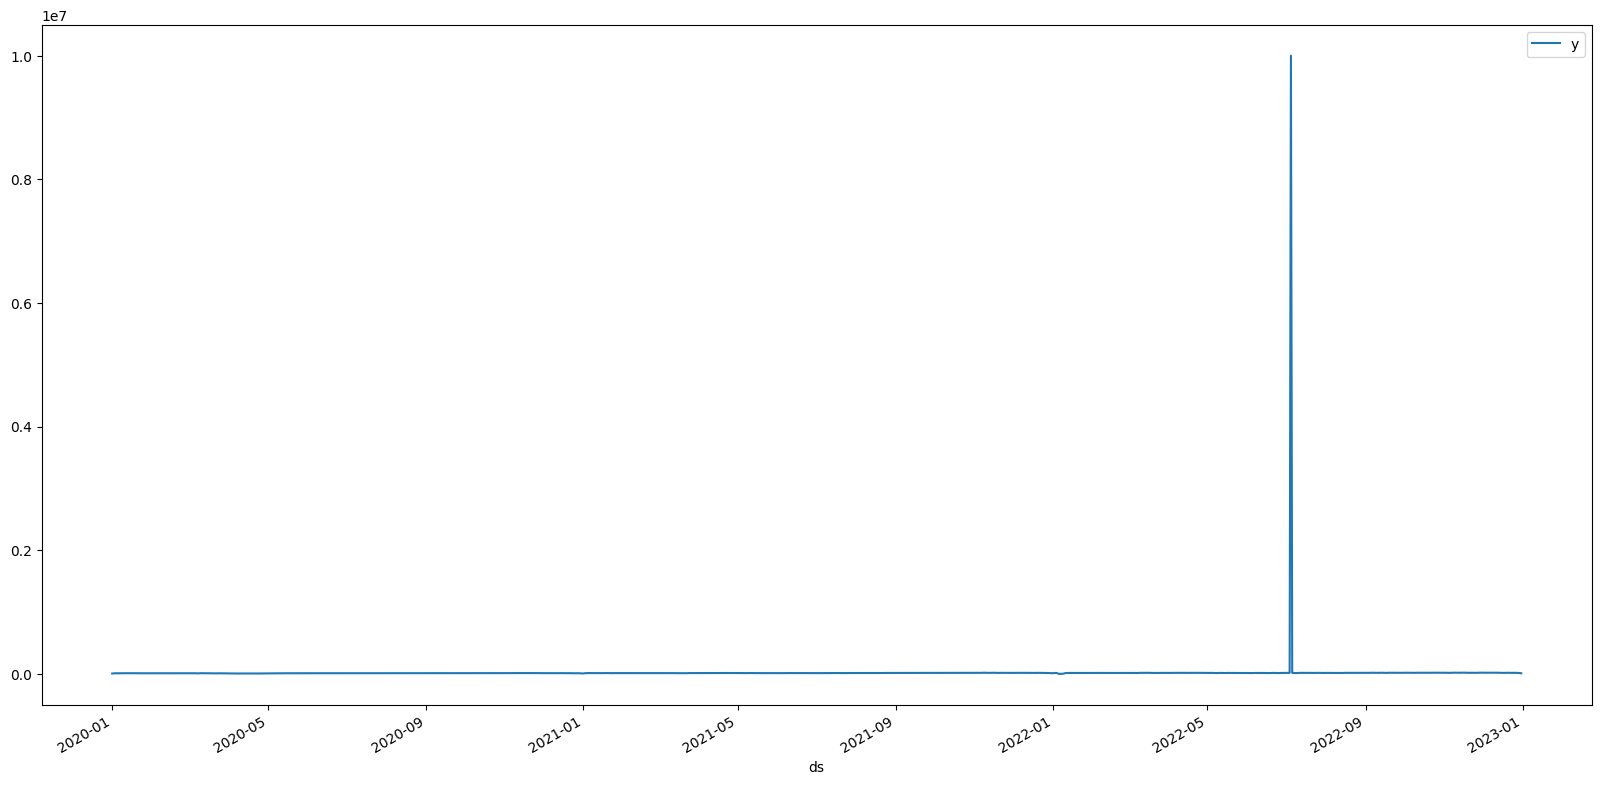

In [57]:
data.plot(x="ds",y="y",kind="line", figsize=(20, 10));


In [58]:
data[data.y == data.y.max()]


,ds,y
ds,,
2022-07-05,2022-07-05,10000000


In [59]:
data[(data.ds >= '2022-07-04') & (data.ds <= '2022-07-06')]


,ds,y
ds,,
2022-07-04,2022-07-04,15767
2022-07-05,2022-07-05,10000000
2022-07-06,2022-07-06,15341


In [60]:
cleaned_data = data.replace(10000000, (15767 + 15341) // 2)


In [61]:
cleaned_data


,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435
...,...,...
2022-12-27,2022-12-27,17042
2022-12-28,2022-12-28,16195
2022-12-29,2022-12-29,14966


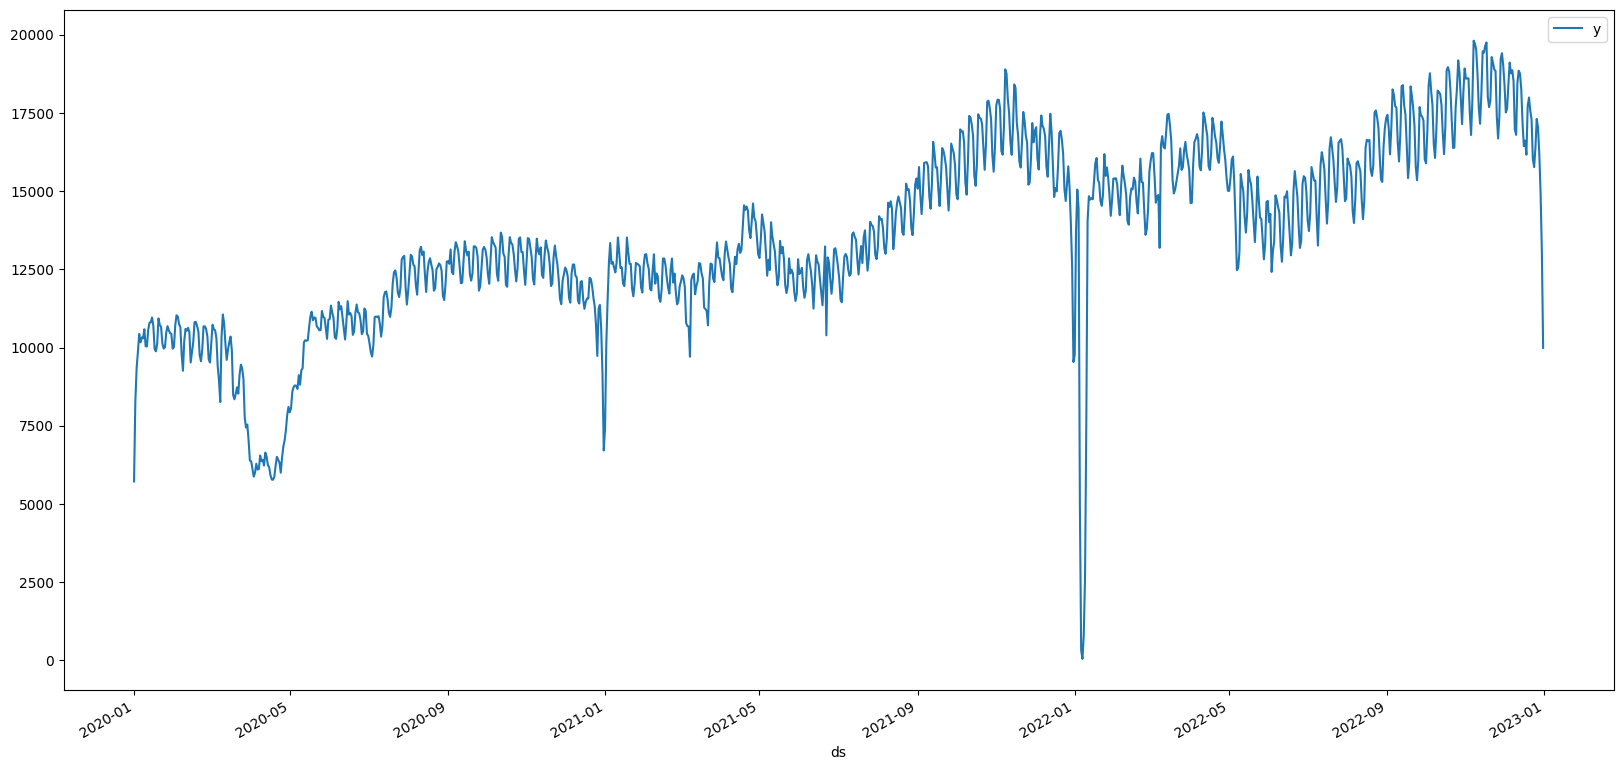

In [62]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10));


# Январские события

In [63]:
cleaned_data[(cleaned_data.ds >= '2021-01-01') & (cleaned_data.ds <= '2021-01-25')]

,ds,y
ds,,
2021-01-01,2021-01-01,7416
2021-01-02,2021-01-02,10115
2021-01-03,2021-01-03,11512
2021-01-04,2021-01-04,12696
2021-01-05,2021-01-05,13338
2021-01-06,2021-01-06,12677
2021-01-07,2021-01-07,12736
2021-01-08,2021-01-08,12560
2021-01-09,2021-01-09,12401


In [64]:
cleaned_data[(cleaned_data.ds >= '2022-01-01') & (cleaned_data.ds <= '2022-01-25')]

,ds,y
ds,,
2022-01-01,2022-01-01,9772
2022-01-02,2022-01-02,13709
2022-01-03,2022-01-03,15046
2022-01-04,2022-01-04,14441
2022-01-05,2022-01-05,4945
2022-01-06,2022-01-06,324
2022-01-07,2022-01-07,51
2022-01-08,2022-01-08,795
2022-01-09,2022-01-09,2643


In [65]:
date_start = '2022-01-05'
date_end = '2022-01-10'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 14000

<Axes: xlabel='ds'>

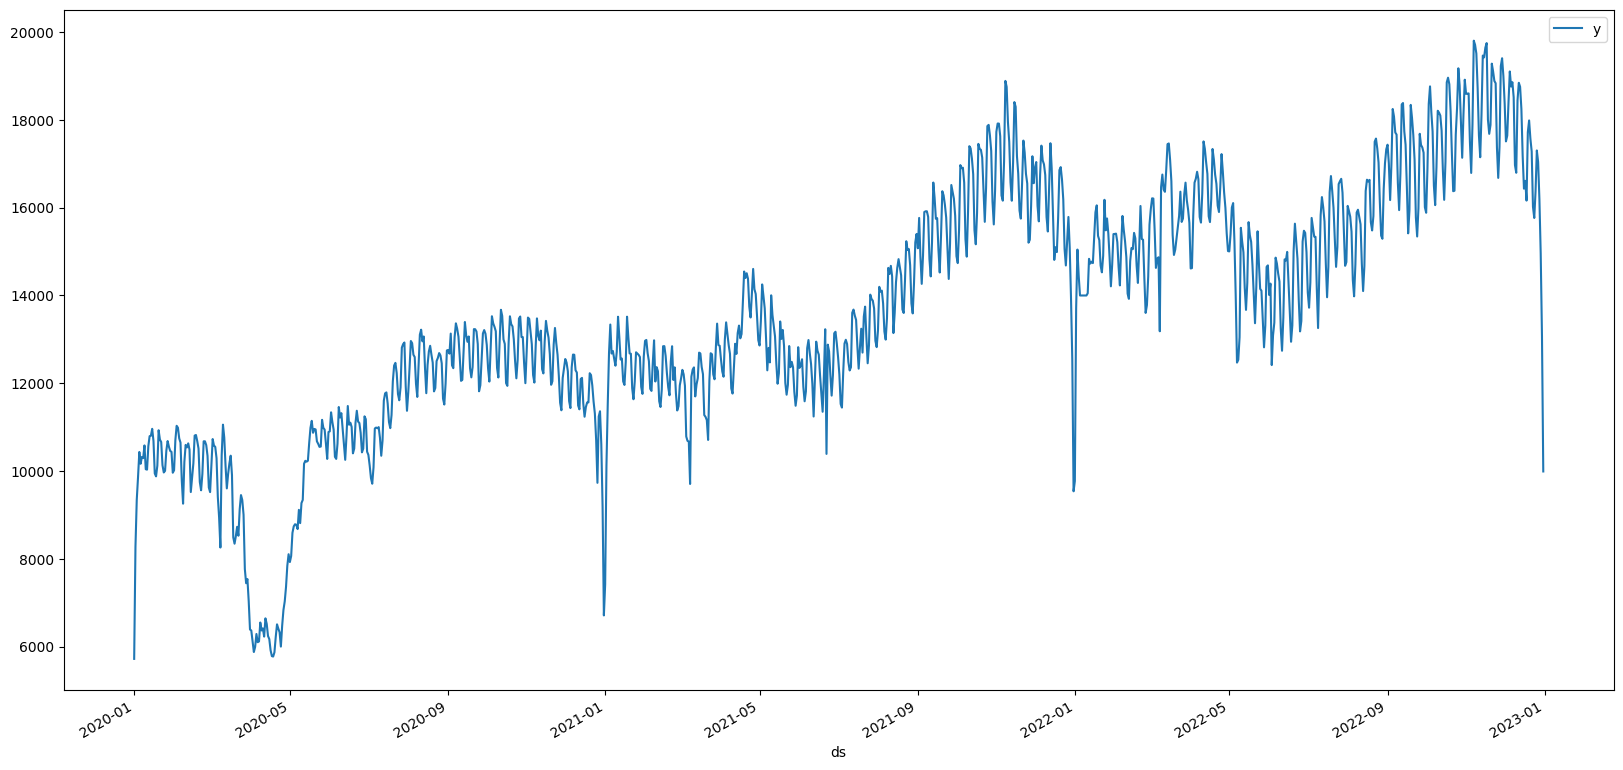

In [66]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10))

# Коронавирус

<Axes: xlabel='ds'>

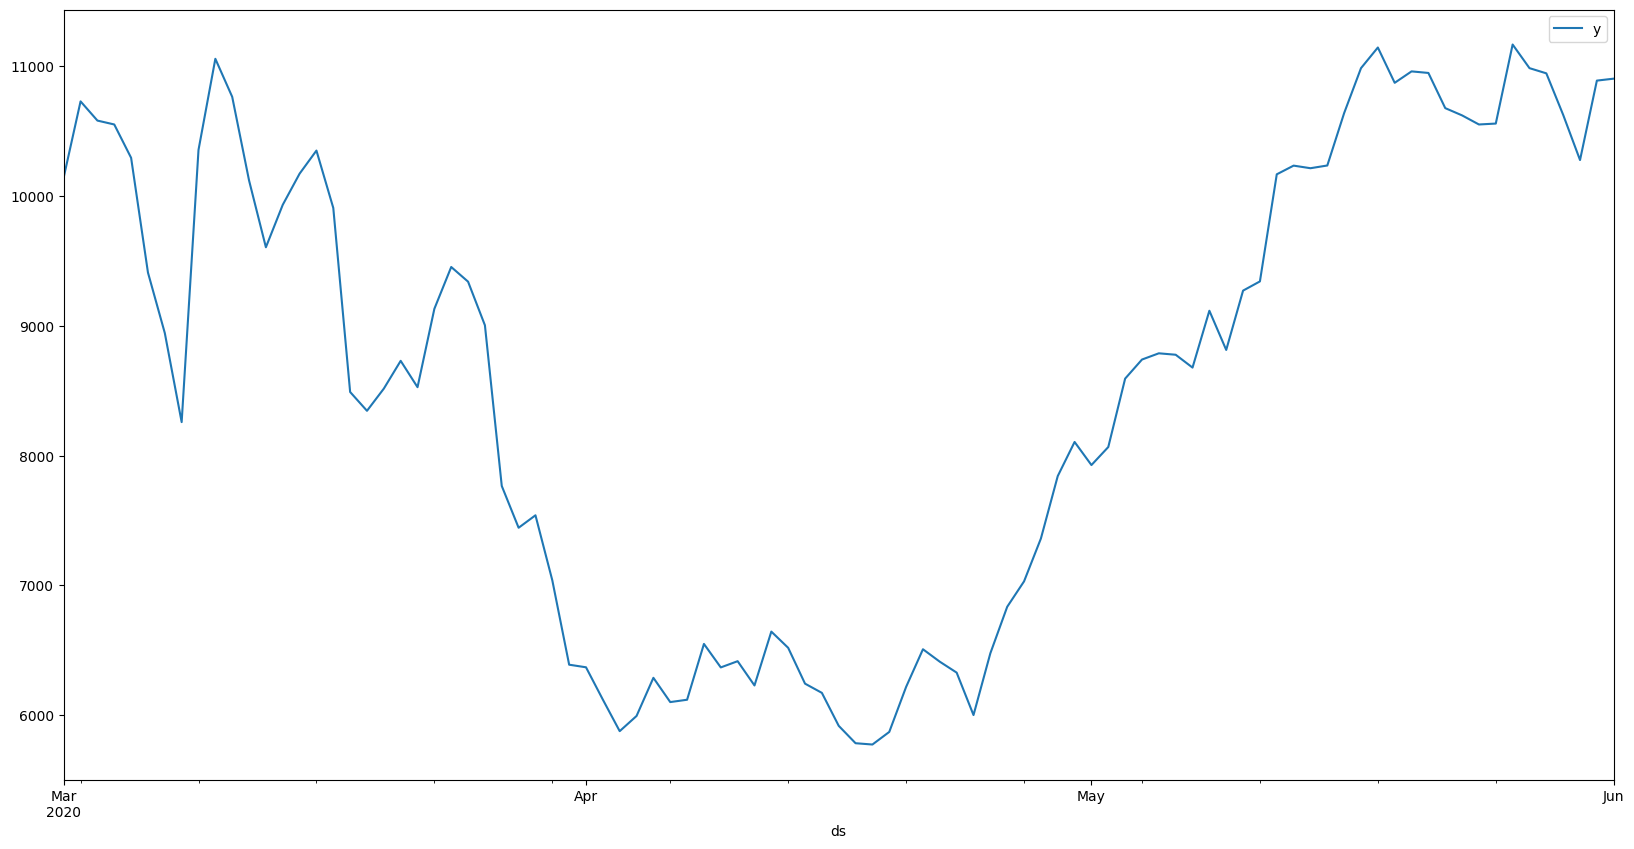

In [67]:
cleaned_data[(cleaned_data.ds >= '2020-03-01') & (cleaned_data.ds <= '2020-06-01')].plot(x="ds",y="y",kind="line", figsize=(20, 10))

<Axes: xlabel='ds'>

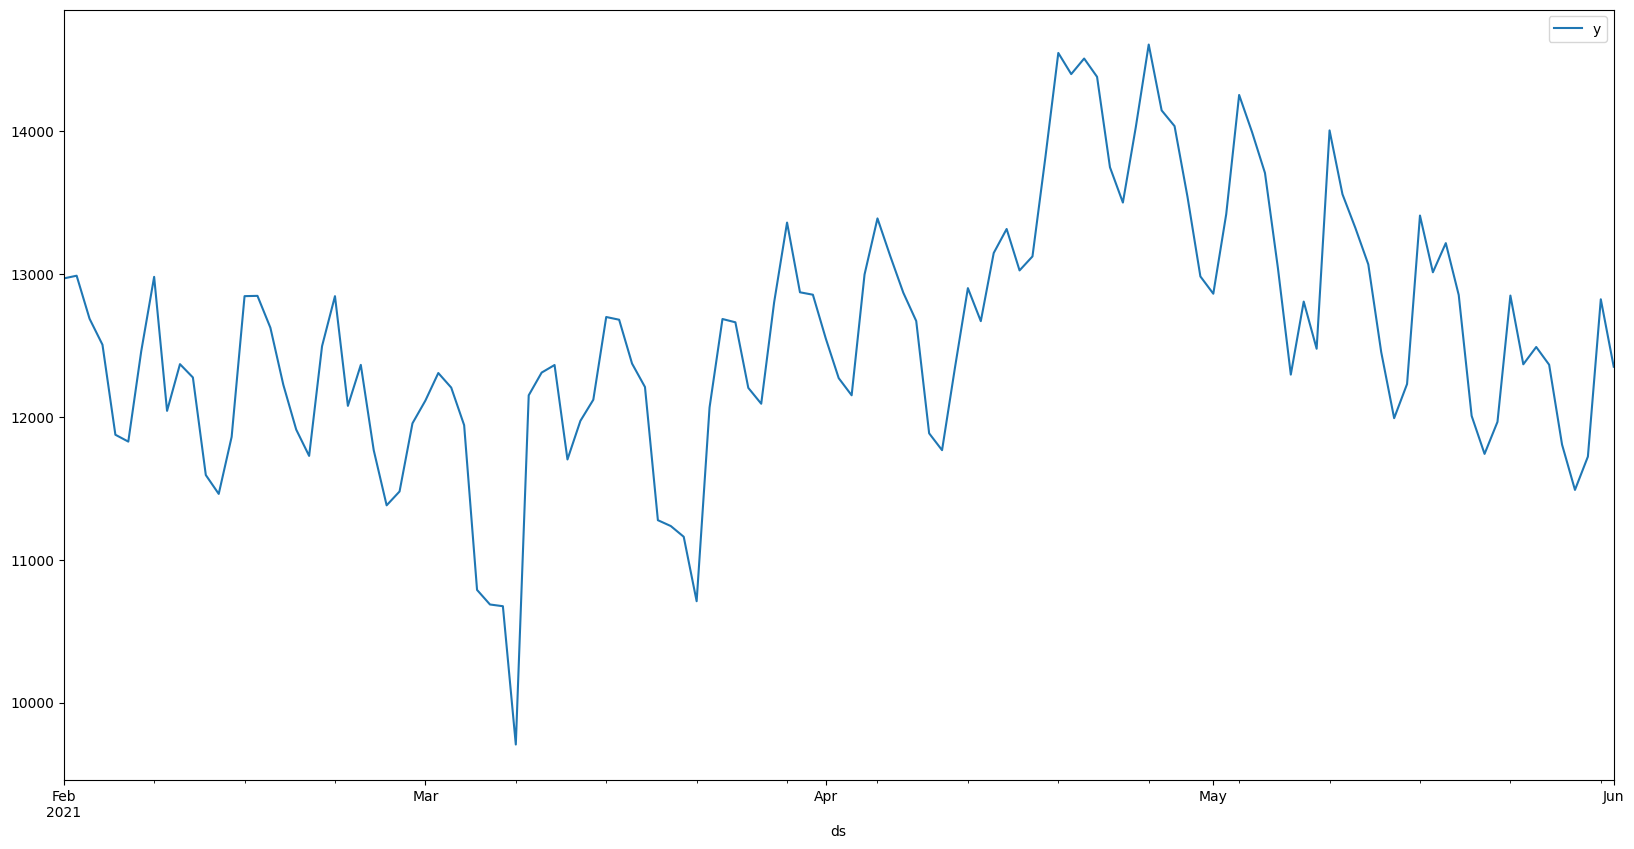

In [68]:
cleaned_data[(cleaned_data.ds >= '2021-02-01') & (cleaned_data.ds <= '2021-06-01')].plot(x="ds",y="y",kind="line", figsize=(20, 10))

In [69]:
date_start = '2020-03-01'
date_end = '2020-06-01'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 11000

<Axes: xlabel='ds'>

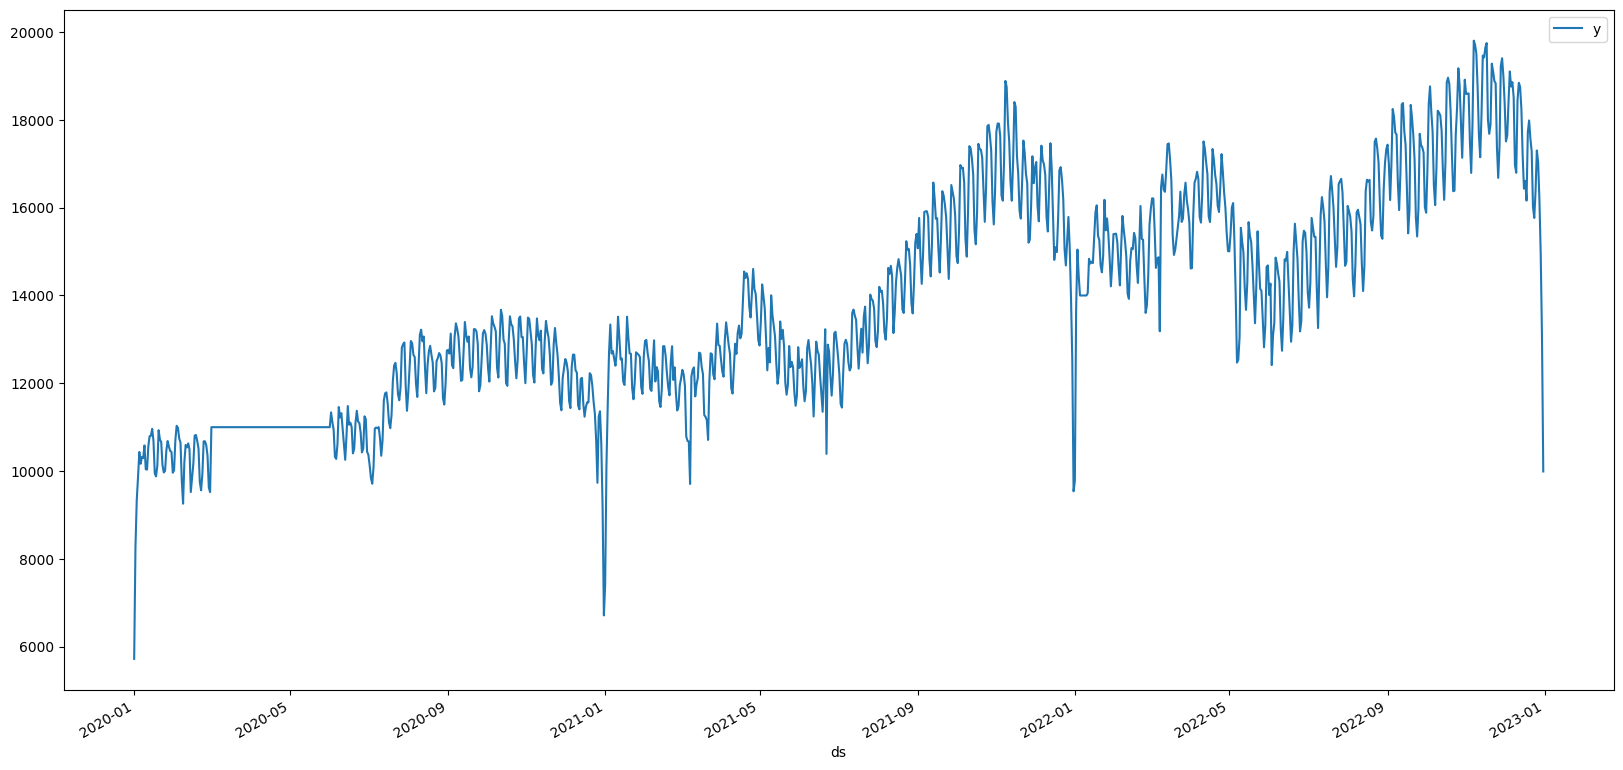

In [70]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10))

# feature engineering

In [71]:
def ramadan(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime("2020-04-24") and date <= pd.to_datetime("2020-05-24")
            or date >= pd.to_datetime("2021-04-13") and date <= pd.to_datetime("2021-05-13")
            or date >= pd.to_datetime("2022-04-03") and date <= pd.to_datetime("2022-05-03")
            or date >= pd.to_datetime("2023-03-23") and date <= pd.to_datetime("2023-04-24"))


cleaned_data['is_ramadan'] = cleaned_data['ds'].apply(ramadan)
cleaned_data['ramadan'] = cleaned_data['is_ramadan'].apply(int)

In [72]:
# Делаем датасет праздников

holidays_kz = holidays.KZ(years=(2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0:'holiday'})
df_holidays['ds'] = df_holidays.index

In [73]:
def get_mape(model,actual):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])
             
             
def plot(model,actual, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"],kind="line", figsize=(10, 10))
    a = add_changepoints_to_plot(ax, model, df_pred,threshold = threshold_changepoints)

In [74]:
cleaned_data

,ds,y,is_ramadan,ramadan
ds,,,,
2020-01-01,2020-01-01,5721,False,0
2020-01-02,2020-01-02,8274,False,0
2020-01-03,2020-01-03,9344,False,0
2020-01-04,2020-01-04,9864,False,0
2020-01-05,2020-01-05,10435,False,0
...,...,...,...,...
2022-12-27,2022-12-27,17042,False,0
2022-12-28,2022-12-28,16195,False,0
2022-12-29,2022-12-29,14966,False,0


In [75]:
initial = str(int(cleaned_data.shape[0]/2)) + ' days'
horizon = str(int(cleaned_data.shape[0]/20)) + ' days'
period = str(int(cleaned_data.shape[0]/20)) + ' days'
print('initial', initial)
print('horizon', horizon)
print('period',  period)

initial 548 days
horizon 54 days
period 54 days


20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. I

('MAPE: ', 0.061569803649462455)

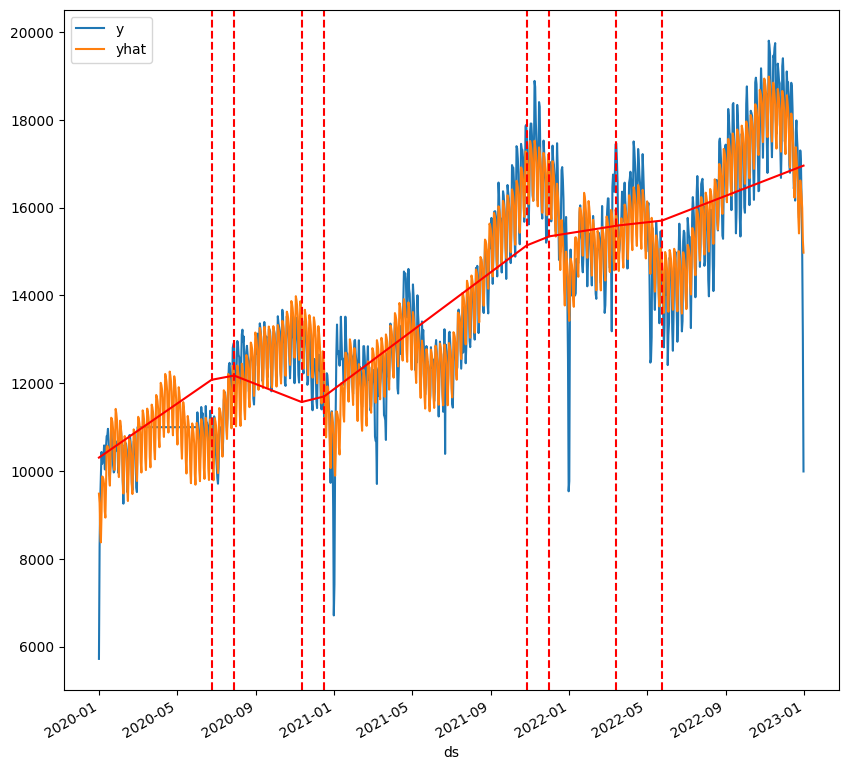

In [76]:
model = Prophet()

model.fit(cleaned_data)

cv_results = cross_validation(model,
                              initial=initial, 
                              period=period, 
                              horizon=horizon, 
                              parallel="processes")
plot(model, cleaned_data)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [77]:
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

Text(0.5, 1.0, 'Default Prophet')

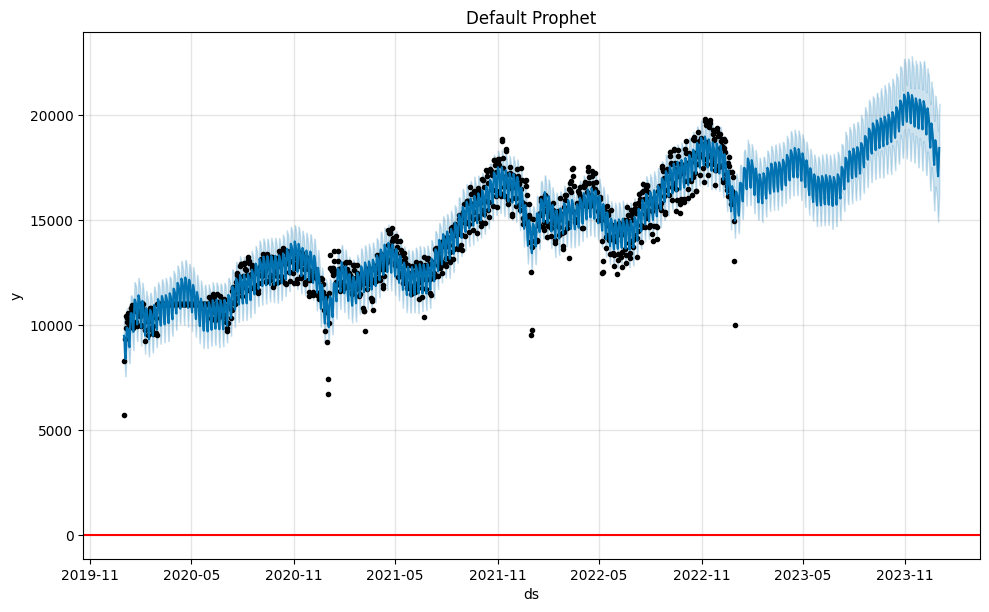

In [78]:
model.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet')

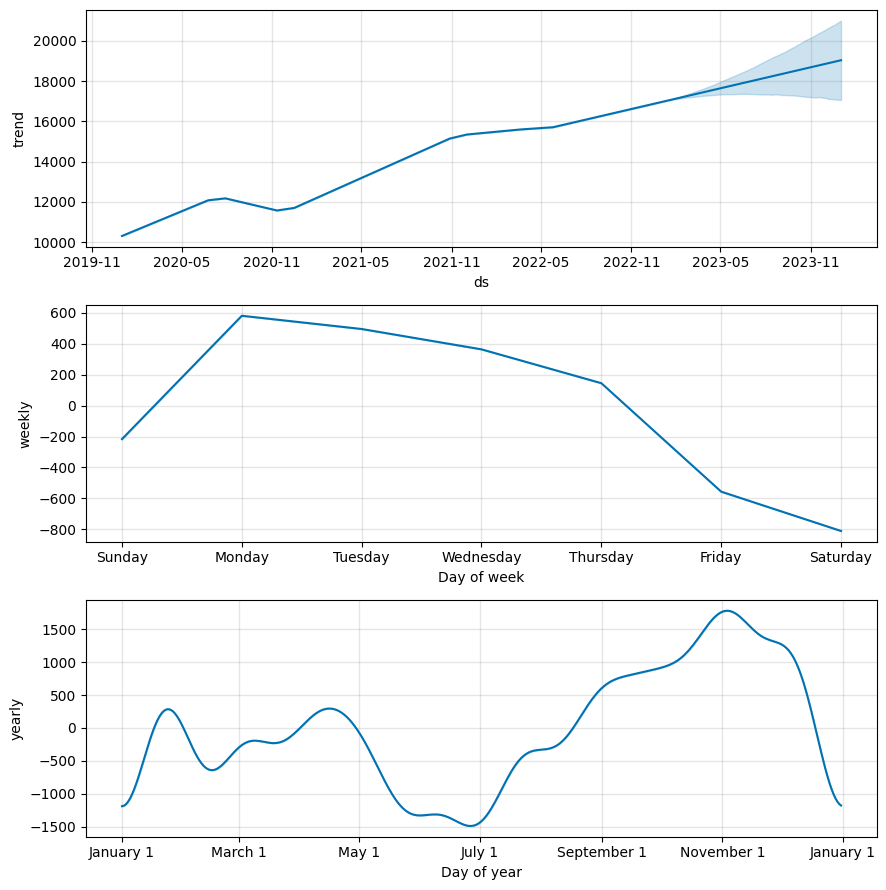

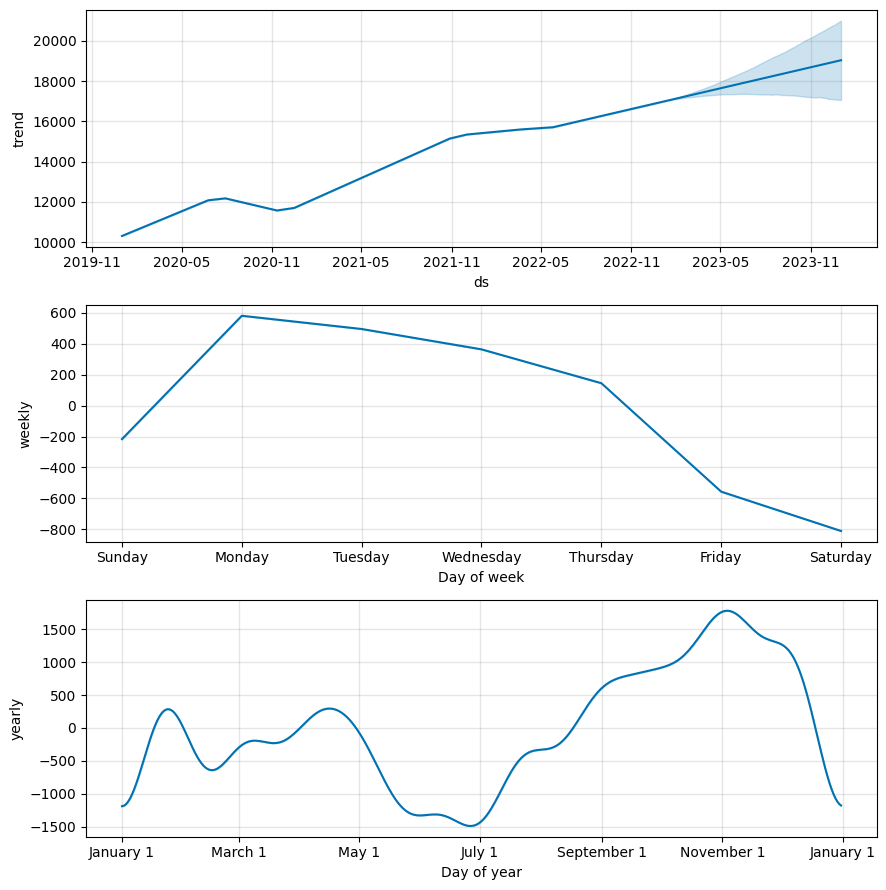

In [79]:
model.plot_components(forecast)

In [80]:
cleaned_data

,ds,y,is_ramadan,ramadan
ds,,,,
2020-01-01,2020-01-01,5721,False,0
2020-01-02,2020-01-02,8274,False,0
2020-01-03,2020-01-03,9344,False,0
2020-01-04,2020-01-04,9864,False,0
2020-01-05,2020-01-05,10435,False,0
...,...,...,...,...
2022-12-27,2022-12-27,17042,False,0
2022-12-28,2022-12-28,16195,False,0
2022-12-29,2022-12-29,14966,False,0


# Улучшим модель

## добавим праздники

In [81]:
df_holidays

,holiday,ds
2017-01-01,New Year,2017-01-01
2017-01-02,New Year,2017-01-02
2017-01-07,Orthodox Christmas,2017-01-07
2017-03-08,International Women's Day,2017-03-08
2017-03-22,Nauryz holiday,2017-03-22
...,...,...
2024-10-25,Republic Day,2024-10-25
2024-12-16,Kazakhstan Independence Day,2024-12-16
2024-03-25,Nauryz holiday (observed),2024-03-25
2024-07-08,Capital Day (observed),2024-07-08


20:44:58 - cmdstanpy - INFO - Chain [1] start processing
20:44:58 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.06106485542137573)

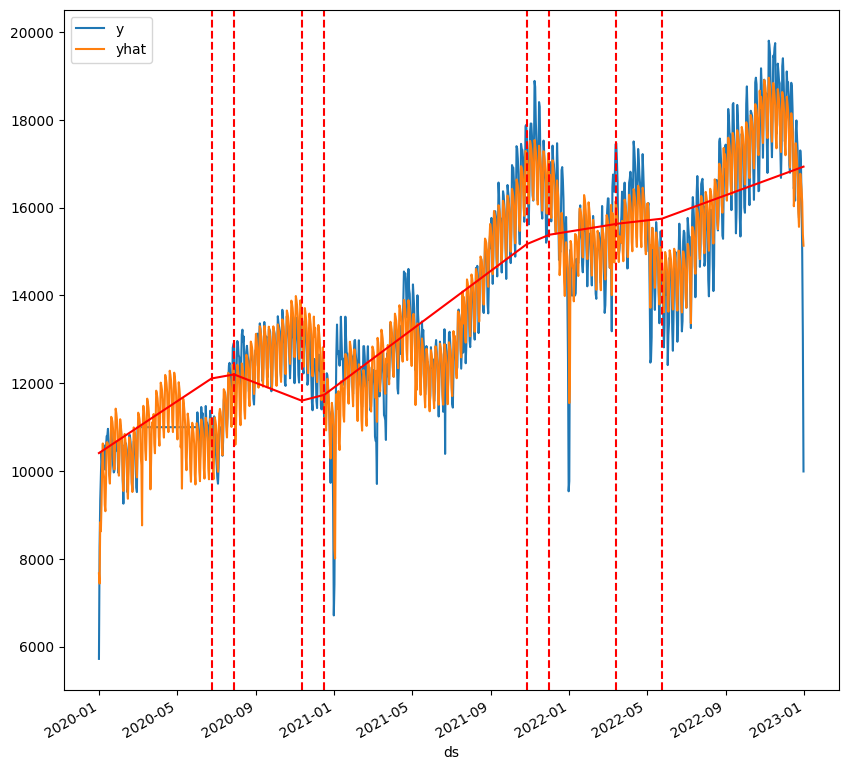

In [82]:
model = Prophet( holidays = df_holidays)

with suppress_stdout_stderr():
    model.fit(cleaned_data)
    
    cv_results = cross_validation(model,
                                  initial=initial, 
                                  period=period, 
                                  horizon=horizon, 
                                  parallel="processes")
plot(model, cleaned_data)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:01 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.0582972988666442)

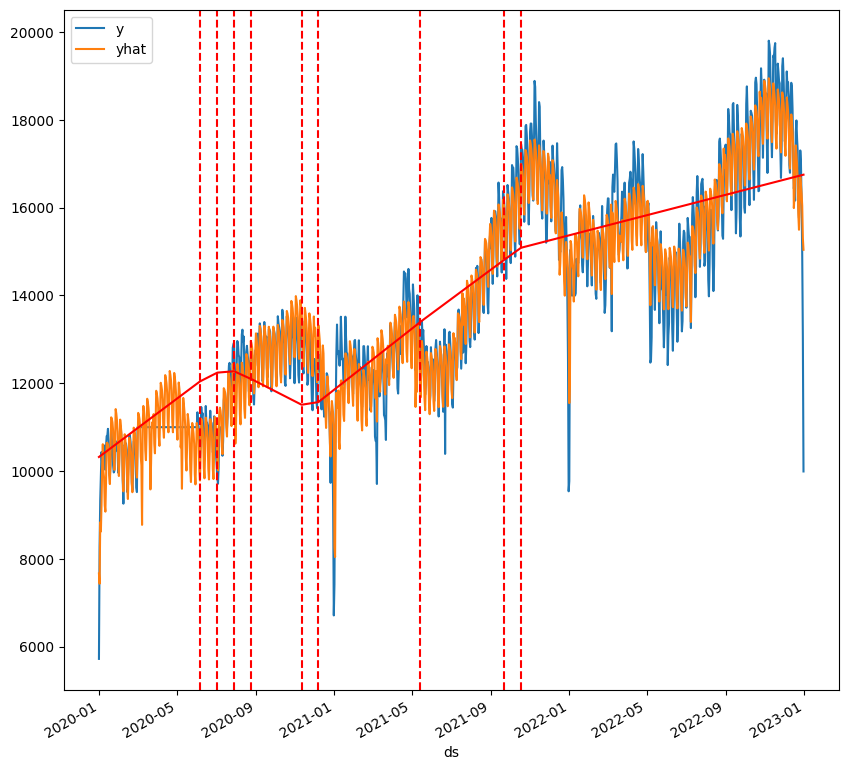

In [83]:
model = Prophet(changepoint_range=0.6, holidays = df_holidays)

with suppress_stdout_stderr():
    model.fit(cleaned_data)

    cv_results = cross_validation(model,
                                  initial=initial, 
                                  period=period, 
                                  horizon=horizon, 
                                  parallel="processes")
plot(model, cleaned_data)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

20:45:07 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.05806288465151088)

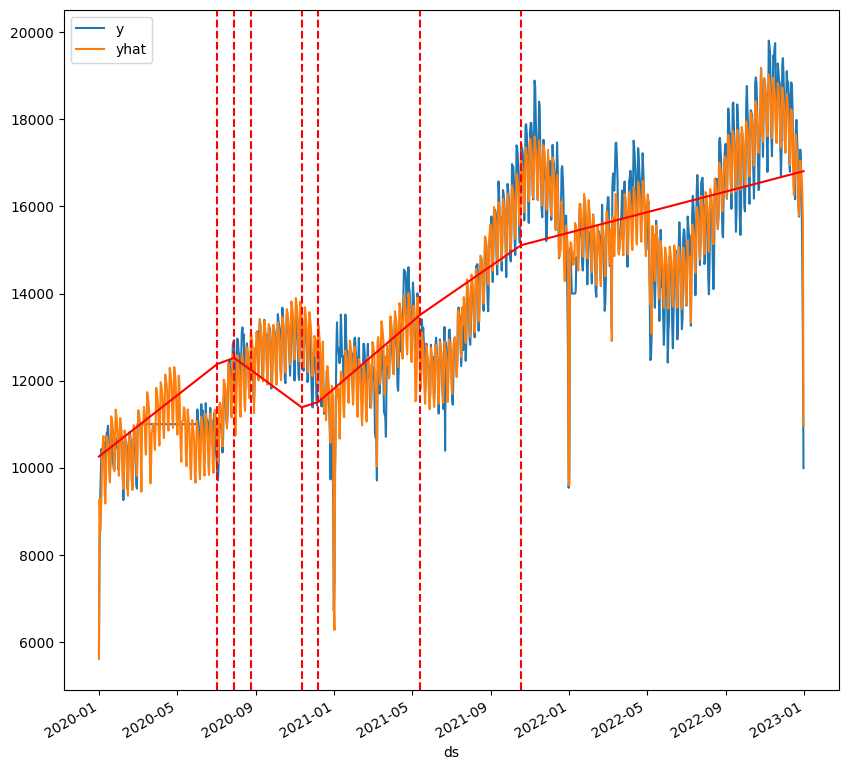

In [84]:
#расширяем окно праздника

df_holidays['lower_window'] = -1
df_holidays['upper_window'] = 1

model = Prophet(changepoint_range=0.6, holidays = df_holidays)

with suppress_stdout_stderr():
    model.fit(cleaned_data)

    cv_results = cross_validation(model, 
                                   initial=initial, 
                                   period=period, 
                                   horizon=horizon, 
                                   parallel="processes")
plot(model,cleaned_data)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

## greed search

In [52]:
def train(params):

    model = Prophet(changepoint_range=0.9, holidays=df_holidays,
                    **params).add_regressor('ramadan')

    with suppress_stdout_stderr():
        model.fit(cleaned_data)
        cv_results = cross_validation(model,
                                      initial=initial,
                                      period=period,
                                      horizon=horizon,
                                      parallel="processes")

    return np.average(performance_metrics(cv_results).mape.values)

In [53]:
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 5, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'seasonality_mode': ['multiplicative', 'additive']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


In [54]:
mapes = []

print(len(all_params))

start_time = time()   
with suppress_stdout_stderr():
    for params in all_params:
        mapes.append(train(params))

print('The time used is ', time()-start_time)
best_params = all_params[np.argmin(mapes)]
print(best_params)
'MAPE', min(mapes)

20:35:44 - cmdstanpy - INFO - Chain [1] start processing
20:35:44 - cmdstanpy - INFO - Chain [1] done processing
20:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:35:44 - cmdstanpy - INFO - Chain [1] start processing


250


20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:51 - cmdstanpy - INFO - Chain [1] start processing
20:35:51 - cmdstanpy - INFO - Chain [1] done processing
20:35:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:35:51 - cmdstanpy - INFO - Chain [1] start processing
20:35:56 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:36:04 - cmdstanpy - INFO - Chain [1] done processing
20:36:06 - cmdstanpy - INFO - Chain [1] start processing
20:36:06 - cmdstanpy - INFO - Chain [1] done processing
20:36:06 - cmdstanpy - ERROR - Chain [1] error: error during proces

Optimization terminated abnormally. Falling back to Newton.
20:38:08 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:14 - cmdstanpy - INFO - Chain [1] start processing
20:38:14 - cmdstanpy - INFO - Chain [1] done processing
20:38:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:38:14 - cmdstanpy - INFO - Chain [1] start processing
20:38:18 - cmdstanpy - INFO - Chain [1] done processing
20:38:20 - cmdstanpy - INFO - Chain [1] start processing
20:38:20 - cmdstanpy - INFO - Chain [1] done processing
20:38:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:38:20 - cmdstanpy - INFO - Chain [1] start processing
20:38:24 - cmdstanpy - INFO - Chain [1] done processing
20:38:26 - cmdstanpy - INFO - Chain [1] start processing
20:38:

20:40:25 - cmdstanpy - INFO - Chain [1] start processing
20:40:25 - cmdstanpy - INFO - Chain [1] done processing
20:40:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:40:25 - cmdstanpy - INFO - Chain [1] start processing
20:40:29 - cmdstanpy - INFO - Chain [1] done processing
20:40:31 - cmdstanpy - INFO - Chain [1] start processing
20:40:31 - cmdstanpy - INFO - Chain [1] done processing
20:40:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:40:31 - cmdstanpy - INFO - Chain [1] start processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing
20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:38 - cmdstanpy - INFO - Chain [1] done processing
20:40:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:45 - cmdstanpy - INFO - Chain [1] start processing
20:42:45 - cmdstanpy - INFO - Chain [1] done processing
20:42:46 - cmdstanpy - INFO - Chain [1] start processing
20:42:47 - cmdstanpy - INFO - Chain [1] done processing
20:42:49 - cmdstanpy - INFO - Chain [1] start processing
20:42:49 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:51 - cmdstanpy - INFO - Chain [1] done processing
20:42:52 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing
20:42:54 - cmdstanpy - INFO - Chain [1] start processing
20:42:54 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:58 - cmdstanpy - INFO - Chain [1] start processing
20:42:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:00 - cmdstanpy - INFO - Chain [1] 

20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:16 - cmdstanpy - INFO - Chain [1] start processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:23 - cmdstanpy - INFO - Chain [1] start processing
20:45:23 - cmdstanpy - INFO - Chain [1] done processing
20:45:25 - cmdstanpy - INFO - Chain [1] start processing
20:45:25 - cmdstanpy - INFO - Chain [1] done processing
20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:29 - cmdstanpy - INFO - Chain [1] start processing
20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] 

20:48:49 - cmdstanpy - INFO - Chain [1] done processing
20:48:51 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing


The time used is  790.5430283546448
{'changepoint_prior_scale': 0.49999999999999994, 'seasonality_prior_scale': 10.000000000000007, 'holidays_prior_scale': 1.0000000000000004, 'seasonality_mode': 'additive'}


('MAPE', 0.05211439018389737)

In [63]:
best_params

{'changepoint_prior_scale': 0.49999999999999994,
 'seasonality_prior_scale': 10.000000000000007,
 'holidays_prior_scale': 1.0000000000000004,
 'seasonality_mode': 'additive'}

21:03:33 - cmdstanpy - INFO - Chain [1] start processing
21:03:34 - cmdstanpy - INFO - Chain [1] done processing


('MAPE', 0.053922953200329665)

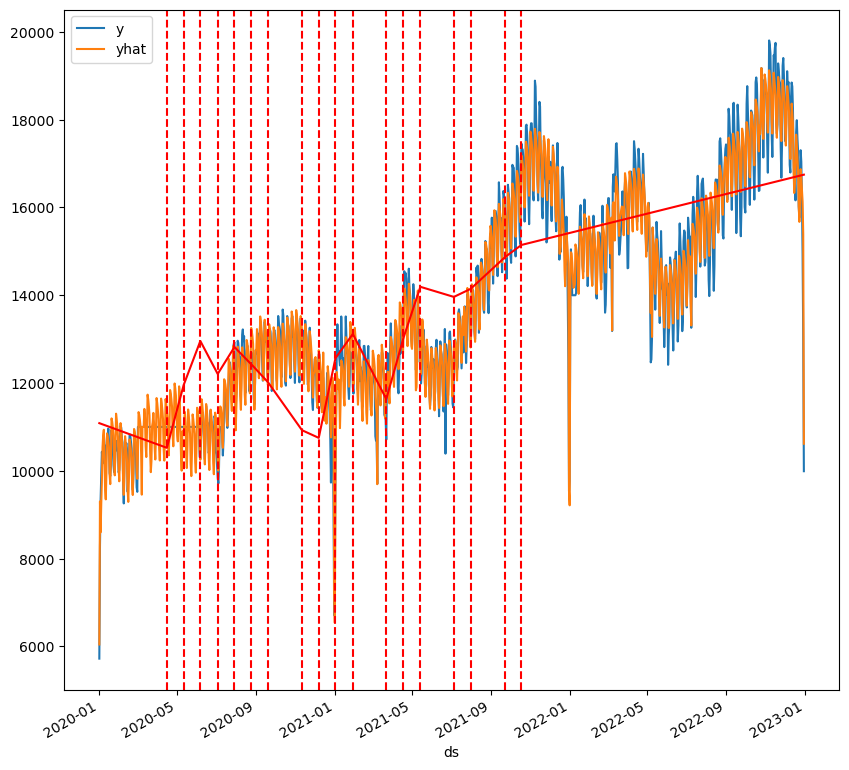

In [70]:
model = Prophet(changepoint_range=0.6, holidays=df_holidays,
                **best_params)
with suppress_stdout_stderr():
    model.fit(cleaned_data)
    cv_results = cross_validation(model,
                                  initial=initial,
                                  horizon=horizon,
                                  parallel="processes")
plot(model, cleaned_data)
'MAPE', np.average(performance_metrics(cv_results).mape.values)

In [71]:
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

Text(0.5, 1.0, 'Default Prophet')

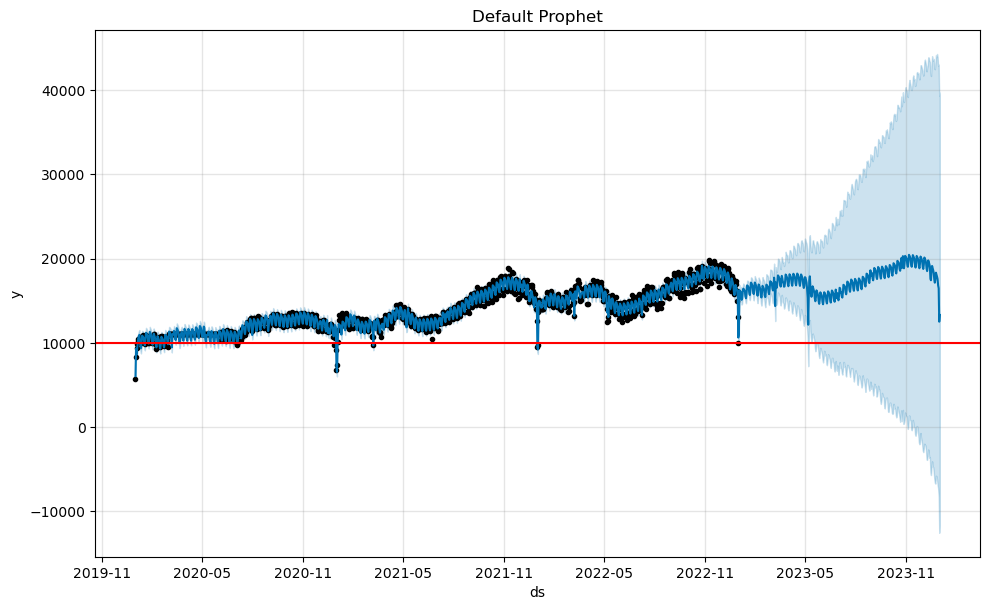

In [72]:
model.plot(forecast)
plt.axhline(y = 10000, color='red')
plt.title('Default Prophet')

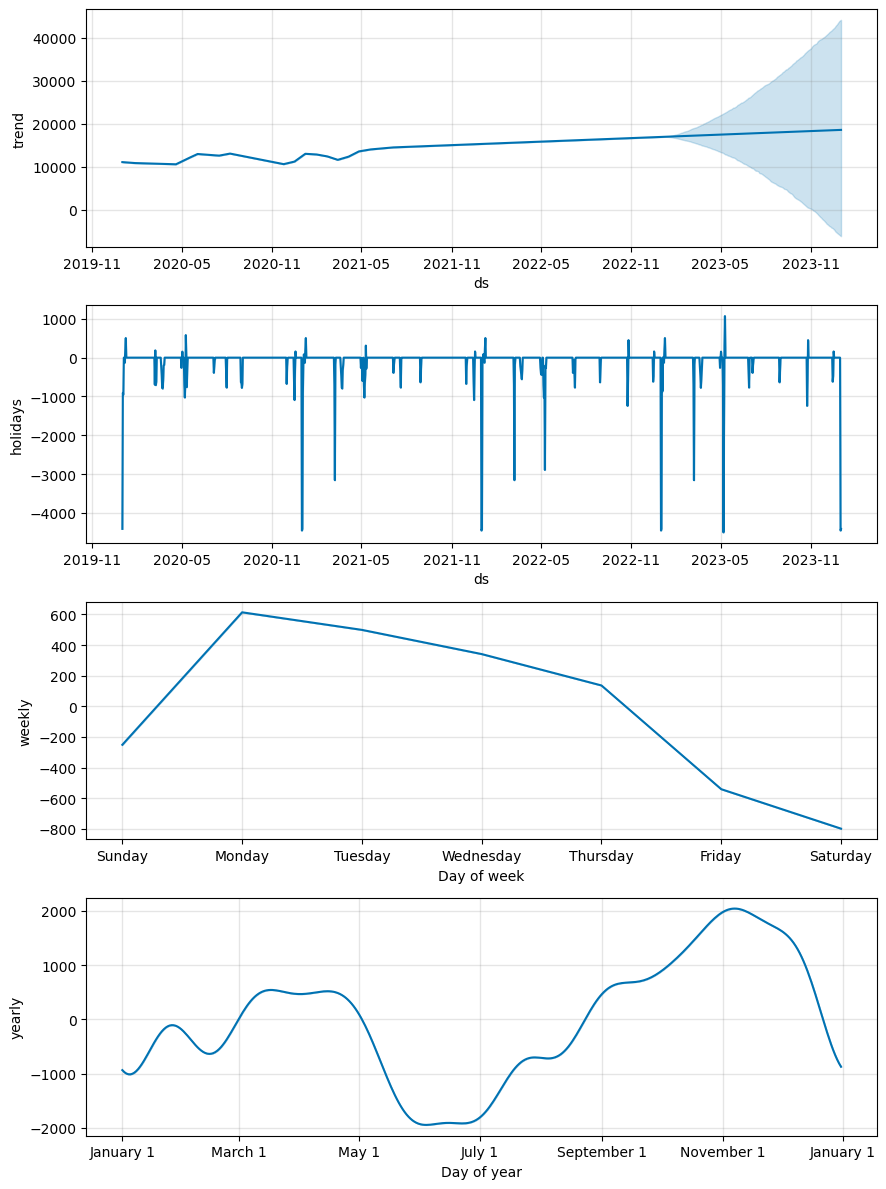

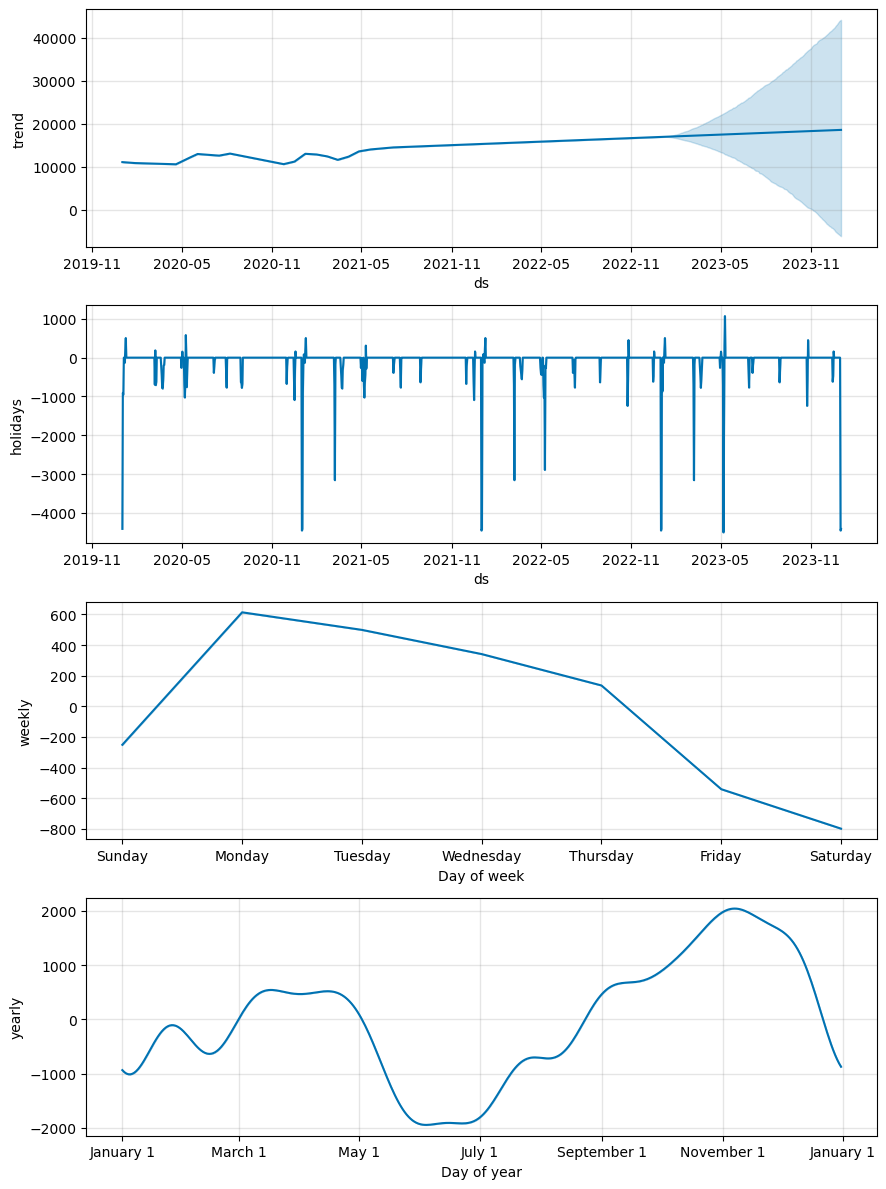

In [69]:
model.plot_components(forecast)

# Лучшая модель

20:45:52 - cmdstanpy - INFO - Chain [1] start processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.05732285965825807)

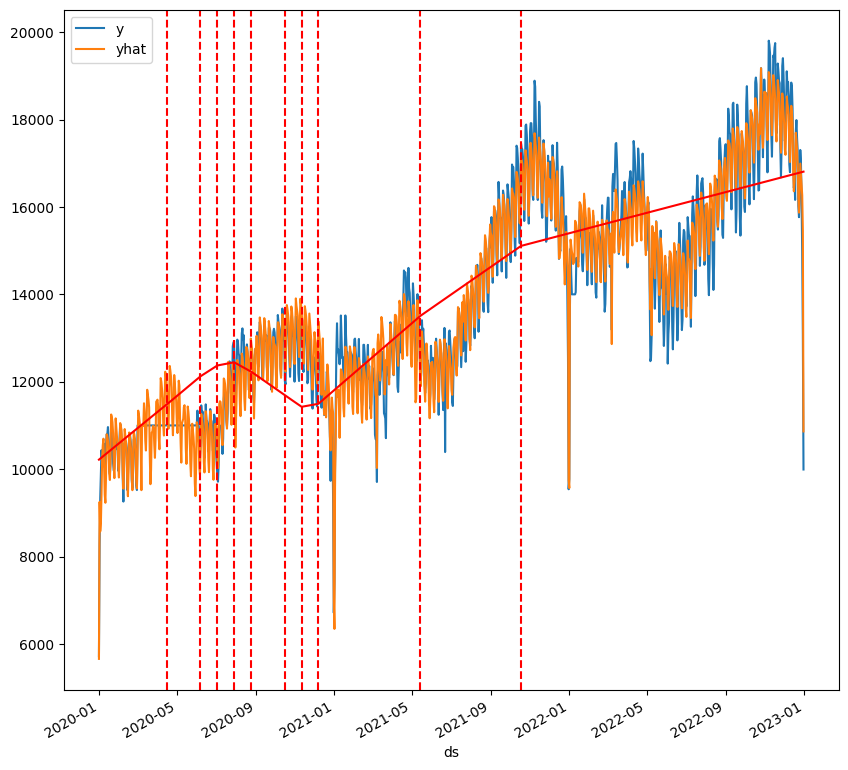

In [86]:
df_holidays['lower_window'] = -1
df_holidays['upper_window'] = 1

model = Prophet(changepoint_range=0.6, holidays = df_holidays)
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

with suppress_stdout_stderr():
    model.fit(cleaned_data)

    cv_results = cross_validation(model, 
                                   initial=initial, 
                                   period=period, 
                                   horizon=horizon, 
                                   parallel="processes")
plot(model,cleaned_data)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [92]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

Text(0.5, 1.0, 'Default Prophet')

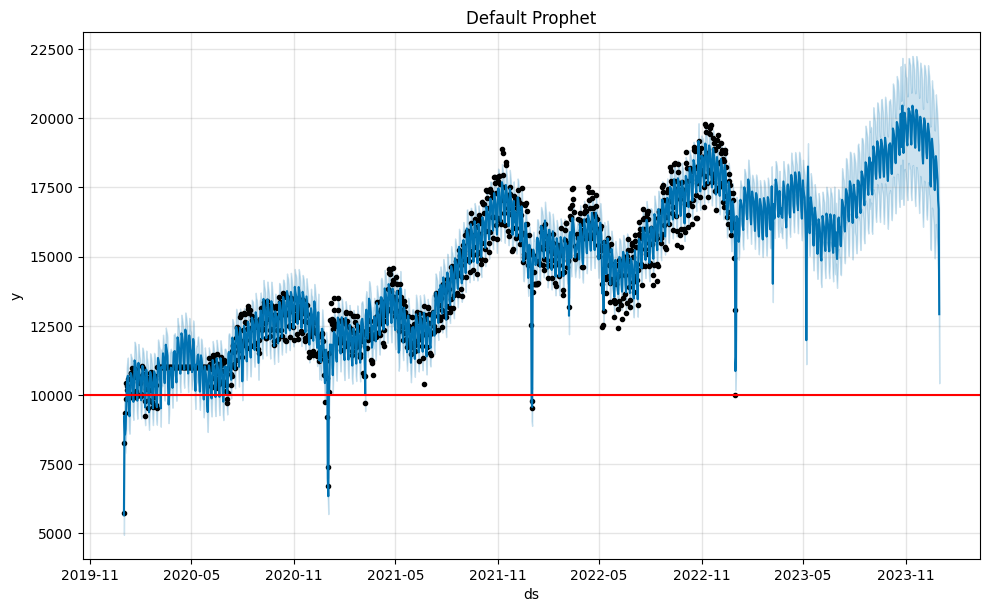

In [93]:
model.plot(forecast)
plt.axhline(y = 10000, color='red')
plt.title('Default Prophet')

In [94]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Capital Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,10216.686520,4950.380980,6263.428027,10216.686520,10216.686520,0.0,0.0,0.0,0.0,...,352.671017,352.671017,352.671017,-636.308959,-636.308959,-636.308959,0.0,0.0,0.0,5657.170667
1,2020-01-02,10228.665814,8569.447906,9939.295205,10228.665814,10228.665814,0.0,0.0,0.0,0.0,...,138.855073,138.855073,138.855073,-652.992959,-652.992959,-652.992959,0.0,0.0,0.0,9249.086142
2,2020-01-03,10240.645108,7901.030869,9253.419740,10240.645108,10240.645108,0.0,0.0,0.0,0.0,...,-543.294984,-543.294984,-543.294984,-659.340283,-659.340283,-659.340283,0.0,0.0,0.0,8575.279784
3,2020-01-04,10252.624402,8109.951529,9400.660474,10252.624402,10252.624402,0.0,0.0,0.0,0.0,...,-799.006090,-799.006090,-799.006090,-655.505302,-655.505302,-655.505302,0.0,0.0,0.0,8761.584079
4,2020-01-05,10264.603696,8751.973839,10082.818431,10264.603696,10264.603696,0.0,0.0,0.0,0.0,...,-253.839075,-253.839075,-253.839075,-641.820044,-641.820044,-641.820044,0.0,0.0,0.0,9440.190754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,18205.623900,15661.716713,20283.606342,15873.589051,20322.712311,0.0,0.0,0.0,0.0,...,352.671017,352.671017,352.671017,-404.677933,-404.677933,-404.677933,0.0,0.0,0.0,18101.831464
1455,2023-12-28,18209.495632,15345.220195,19942.310557,15870.426727,20337.327046,0.0,0.0,0.0,0.0,...,138.855073,138.855073,138.855073,-469.285049,-469.285049,-469.285049,0.0,0.0,0.0,17760.794867
1456,2023-12-29,18213.367365,14569.355585,19366.299561,15867.287328,20351.638303,0.0,0.0,0.0,0.0,...,-543.294984,-543.294984,-543.294984,-525.351734,-525.351734,-525.351734,0.0,0.0,0.0,17023.925655
1457,2023-12-30,18217.239097,14334.713802,19029.386362,15864.431849,20365.527964,0.0,0.0,0.0,0.0,...,-799.006090,-799.006090,-799.006090,-572.203703,-572.203703,-572.203703,0.0,0.0,0.0,16714.606881


In [96]:
forecast.tail(365)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Capital Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1094,2023-01-01,16811.800283,10735.409241,12028.992465,16811.800283,16811.800283,0.0,0.0,0.0,0.0,...,-253.839075,-253.839075,-253.839075,-641.450735,-641.450735,-641.450735,0.0,0.0,0.0,11370.537810
1095,2023-01-02,16815.672015,15819.879427,17159.900638,16815.672015,16815.672015,0.0,0.0,0.0,0.0,...,606.928076,606.928076,606.928076,-655.545882,-655.545882,-655.545882,0.0,0.0,0.0,16464.051658
1096,2023-01-03,16819.543747,15673.814423,16994.425272,16819.543747,16819.543747,0.0,0.0,0.0,0.0,...,497.685983,497.685983,497.685983,-659.326172,-659.326172,-659.326172,0.0,0.0,0.0,16329.229286
1097,2023-01-04,16823.415480,15782.850080,17047.183201,16823.415480,16823.415480,0.0,0.0,0.0,0.0,...,352.671017,352.671017,352.671017,-652.990630,-652.990630,-652.990630,0.0,0.0,0.0,16385.473966
1098,2023-01-05,16827.287212,15533.726414,16910.618656,16827.287212,16827.287212,0.0,0.0,0.0,0.0,...,138.855073,138.855073,138.855073,-636.915100,-636.915100,-636.915100,0.0,0.0,0.0,16252.706511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,18205.623900,15661.716713,20283.606342,15873.589051,20322.712311,0.0,0.0,0.0,0.0,...,352.671017,352.671017,352.671017,-404.677933,-404.677933,-404.677933,0.0,0.0,0.0,18101.831464
1455,2023-12-28,18209.495632,15345.220195,19942.310557,15870.426727,20337.327046,0.0,0.0,0.0,0.0,...,138.855073,138.855073,138.855073,-469.285049,-469.285049,-469.285049,0.0,0.0,0.0,17760.794867
1456,2023-12-29,18213.367365,14569.355585,19366.299561,15867.287328,20351.638303,0.0,0.0,0.0,0.0,...,-543.294984,-543.294984,-543.294984,-525.351734,-525.351734,-525.351734,0.0,0.0,0.0,17023.925655
1457,2023-12-30,18217.239097,14334.713802,19029.386362,15864.431849,20365.527964,0.0,0.0,0.0,0.0,...,-799.006090,-799.006090,-799.006090,-572.203703,-572.203703,-572.203703,0.0,0.0,0.0,16714.606881


In [97]:
result = forecast.tail(365)

In [101]:
result = result[['ds','yhat']]
result

,ds,yhat
1094,2023-01-01,11370.537810
1095,2023-01-02,16464.051658
1096,2023-01-03,16329.229286
1097,2023-01-04,16385.473966
1098,2023-01-05,16252.706511
...,...,...
1454,2023-12-27,18101.831464
1455,2023-12-28,17760.794867
1456,2023-12-29,17023.925655
1457,2023-12-30,16714.606881


In [104]:
result.to_excel('forecast_results.xlsx', index=False)

In [105]:
forecast_results = pd.read_excel('forecast_results.xlsx')
forecast_results

,ds,yhat,linreg,destree
0,2023-01-01,11370.537810,15928.167464,14962.140000
1,2023-01-02,16464.051658,17241.700747,15811.500000
2,2023-01-03,16329.229286,17024.554434,15618.500000
3,2023-01-04,16385.473966,16807.408120,15672.328767
4,2023-01-05,16252.706511,16590.261806,15672.328767
...,...,...,...,...
360,2023-12-27,18101.831464,20197.439171,18397.208333
361,2023-12-28,17760.794867,19980.292857,18397.208333
362,2023-12-29,17023.925655,19763.146544,16990.250000
363,2023-12-30,16714.606881,19546.000230,16990.250000
